# Fouth model: Random forest with TFIDF + complexity features

In [55]:
import time
start = time.time()

import nltk
from nltk.corpus import stopwords  
from nltk import word_tokenize, sent_tokenize
from nltk.data import load  
from nltk.stem import SnowballStemmer  
from string import punctuation

import itertools
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score

In [26]:
df = pd.read_csv('../data/spanish_corpus_features_v2.csv')
df.head()

,headline,text,n_sentences_text,n_words_text,avg_words_sent_text,avg_word_size_text,ttr_text,n_words_headline,avg_word_size_headline,ttr_headline,label
0,sofía castro y alejandro peña pretelini: una i...,sofía castro y alejandro peña pretelini: una i...,5,123,24.600000,6.398374,69.105691,8,7.500000,100.0,1
1,un paso más cerca de hacer los exámenes 'online',un paso más cerca de hacer los exámenes 'onlin...,8,224,28.000000,7.205357,77.232143,5,5.800000,100.0,1
2,esto es lo que los científicos realmente piens...,esto es lo que los científicos realmente piens...,29,467,16.103448,7.573876,64.668094,4,9.500000,100.0,1
3,inicia impresión de boletas para elección pres...,inicia impresión de boletas para elección pres...,10,167,16.700000,7.964072,63.473054,5,8.400000,100.0,1
4,a *number* día del mundial,a *number* día del mundial\nfifa.com sigue la ...,4,57,14.250000,7.368421,84.210526,3,5.333333,100.0,1


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 971 entries, 0 to 970
Data columns (total 11 columns):
headline                  971 non-null object
text                      971 non-null object
n_sentences_text          971 non-null int64
n_words_text              971 non-null int64
avg_words_sent_text       971 non-null float64
avg_word_size_text        971 non-null float64
ttr_text                  971 non-null float64
n_words_headline          971 non-null int64
avg_word_size_headline    971 non-null float64
ttr_headline              971 non-null float64
label                     971 non-null int64
dtypes: float64(5), int64(4), object(2)
memory usage: 83.6+ KB


In [28]:
df.columns

Index(['headline', 'text', 'n_sentences_text', 'n_words_text',
       'avg_words_sent_text', 'avg_word_size_text', 'ttr_text',
       'n_words_headline', 'avg_word_size_headline', 'ttr_headline', 'label'],
      dtype='object')

In [29]:
y = df['label']

## Spanish tokenization

    - Spanish stopwords
    - Added more spanish punctuation
    - Created stems with lemmas, using the rooting word

In [30]:
#Stopword list to use
spanish_stopwords = stopwords.words('spanish')

In [31]:
#Spanish stemmer: Stemming is the process to transform any word into its rooting word, considering them as the same word
stemmer = SnowballStemmer('spanish')

def stem_tokens(tokens, stemmer):  
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

In [32]:
#Punctuation to remove
non_words = list(punctuation)

#Adding spanish punctuation
non_words.extend(['¿', '¡'])  
non_words.extend(map(str,range(10)))

In [33]:
def tokenize(text):  
    #Remove punctuation
    text = ''.join([c for c in text if c not in non_words])
    #Tokenize
    tokens =  word_tokenize(text)

    #Stem
    try:
        stems = stem_tokens(tokens, stemmer)
    except Exception as e:
        print(e)
        print(text)
        stems = ['']
    return stems

## TFIDF Vectorizer transformation with the tokenization explaned

In [34]:
tfidf_vectorizer = TfidfVectorizer(  
                analyzer = 'word',
                tokenizer = tokenize,
                lowercase = True,
                stop_words = spanish_stopwords)

### Transformation

In [35]:
text_vectorized = tfidf_vectorizer.fit_transform(df['text']) 

/home/pipe11/.local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['algun', 'com', 'contr', 'cuand', 'desd', 'dond', 'durant', 'eram', 'estab', 'estais', 'estam', 'estan', 'estand', 'estaran', 'estaras', 'esteis', 'estem', 'esten', 'estes', 'estuv', 'fuer', 'fues', 'fuim', 'fuist', 'hab', 'habr', 'habran', 'habras', 'hast', 'hem', 'hub', 'mas', 'mia', 'mias', 'mio', 'mios', 'much', 'nad', 'nosotr', 'nuestr', 'par', 'per', 'poc', 'porqu', 'qui', 'seais', 'seam', 'sent', 'ser', 'seran', 'seras', 'si', 'sient', 'sint', 'sobr', 'som', 'suy', 'tambien', 'tant', 'ten', 'tendr', 'tendran', 'tendras', 'teng', 'tien', 'tod', 'tuv', 'tuy', 'vosotr', 'vuestr'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [36]:
tfvocab = tfidf_vectorizer.get_feature_names()

### Make Dense dataframe Sparse, and Combine with TF-IDF features

In [37]:
numerical_features = ['n_sentences_text', 'n_words_text', 'avg_words_sent_text',
       'avg_word_size_text', 'ttr_text', 'n_words_headline',
       'avg_word_size_headline', 'ttr_headline']

X = hstack([csr_matrix(df[numerical_features].values), text_vectorized[0:]])
tfvocab = df[numerical_features].columns.tolist() + tfvocab

for shape in [X]:
    print("{} Rows and {} Cols".format(*shape.shape))
print("Feature Names Length: ", len(tfvocab))

971 Rows and 15613 Cols
Feature Names Length:  15613


### Split into testing set, training set and validation set

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)

# Random Forest

In [40]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)

score = accuracy_score(y_test, y_pred)
accuracy = round(score * 100, 2)

print(roc_auc, accuracy)

0.8464319248826291 84.59


## Random Forest hyperparameters grid search:

    n_estimators = number of trees in the foreset

    max_features = max number of features considered for splitting a node

    max_depth = max number of levels in each decision tree

    min_samples_split = min number of data points placed in a node before the node is split

    min_samples_leaf = min number of data points allowed in a leaf node

    bootstrap = method for sampling data points (with or without replacement)

In [42]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [43]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state = 42, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.1min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [44]:
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': False}

In [45]:
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    errors = abs(y_pred - y_test)
    score = accuracy_score(y_test, y_pred)
    accuracy = round(score * 100, 2)
    print('Model Performance')
    print('Average Error: %f degrees.' %(np.mean(errors)))
    print(f'Accuracy: {round(score * 100, 2)}%')
    
    return accuracy

base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)


best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

print('Improvement of %f.' %( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 0.246575 degrees.
Accuracy: 75.34%
Model Performance
Average Error: 0.167808 degrees.
Accuracy: 83.22%
Improvement of 10.459251.


## Grid search with cross validation

In [46]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [70, 75, 80, 85],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 0.5, 1.5, 2],
    'min_samples_split': [13, 14, 15],
    'n_estimators': [250, 300, 350]
}

{'bootstrap': True, 'max_depth': 80, 'max_features': 'sqrt', 
 'min_samples_leaf': 1, 'min_samples_split': 14, 'n_estimators': 300}

In [47]:
rf = RandomForestClassifier()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [48]:
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
best_grid = grid_search.best_estimator_

grid_accuracy = evaluate(best_grid, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   52.6s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  2.1min finished


{'bootstrap': True, 'max_depth': 80, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 13, 'n_estimators': 350}
Model Performance
Average Error: 0.160959 degrees.
Accuracy: 83.9%
Improvement of 11.36%.


## Predictions & results

In [49]:
y_pred = best_grid.predict(X_test)

In [51]:
score = accuracy_score(y_test, y_pred)
accuracy = round(score * 100, 2)

print('Roc AUC: ', roc_auc, '\nAccuracy: ', accuracy)

Roc AUC:  0.8464319248826291 
Accuracy:  83.9


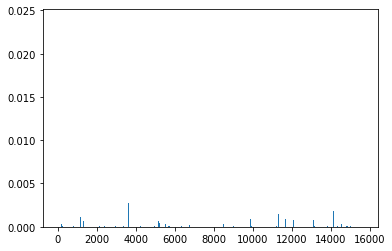

In [56]:
# get importance
importance = best_grid.feature_importances_

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [52]:
cf_matrix = confusion_matrix(y_test, y_pred, labels = [0, 1])
print(cf_matrix)

[[120  30]
 [ 17 125]]


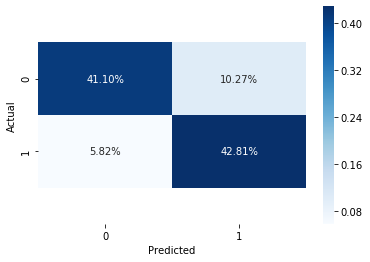

In [53]:
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()